In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 5.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

In [2]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, SimpleRNN, Activation
from keras.optimizers import Adam
from keras.callbacks import Callback

import keras.backend as K

Using Theano backend.
Using gpu device 0: GeForce GTX 670 (CNMeM is disabled, CuDNN 4007)
/home/budmitr/anaconda/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [3]:
def loss(ytrue, ypred):
  return K.sum( (ytrue - ypred) ** 2 )

# Create toy dataframe for multilabel problem

In [4]:
features = ['f1', 'f2']
labels = ['pos', 'neg', 'big', 'small']

In [5]:
def getdata(n, cases, seed=0):
  np.random.seed(seed)
  X = np.random.randn(n, 2)

  data = pd.DataFrame(X, columns=features)
  data['case'] = np.random.randint(1, cases, n)

  datag = data.groupby('case').sum()
  datag['sum'] = datag.f1 + datag.f2
  datag['pos'] = (datag['sum'] >= 0).astype('int')
  datag['neg'] = (datag['sum'] < 0).astype('int')
  datag['big'] = (datag['sum'].apply(lambda v: np.abs(v) > 0.5)).astype('int')
  datag['small'] = (datag['sum'].apply(lambda v: np.abs(v) < 0.5)).astype('int')

  return data.join(datag[['sum'] + labels], on='case').sort_values(['case'])

In [6]:
data_train = getdata(1000, 300)
num_train = len(data_train.case.unique())
data_train.head()

,f1,f2,case,sum,pos,neg,big,small
828,1.148351,-0.910850,1,-0.550354,0,1,1,0
990,-0.789102,0.001248,1,-0.550354,0,1,1,0
179,-0.479656,0.620358,2,-0.796242,0,1,1,0
174,0.578521,0.349654,2,-0.796242,0,1,1,0
267,-1.279689,-0.585431,2,-0.796242,0,1,1,0


In [7]:
data_val = getdata(1000, 300, 1)
num_val = len(data_val.case.unique())
data_val.head()

,f1,f2,case,sum,pos,neg,big,small
938,-1.551658,1.423177,1,1.678447,1,0,1,0
896,0.873674,0.933253,1,1.678447,1,0,1,0
539,-1.987830,0.861289,2,-0.847974,0,1,1,0
383,0.497269,0.237333,2,-0.847974,0,1,1,0
625,-1.023799,0.567765,2,-0.847974,0,1,1,0


In [25]:
def train_generator(n_batches, maxlen, dimin, dimout):
  while True:
    cases = data_train.case.unique()
    shuffled = cases.copy()
    np.random.shuffle(shuffled)
    
    batches = np.array_split(shuffled, n_batches)
    
    for batch in batches:
      X = np.zeros((len(batch), maxlen, dimin))
      Y = np.zeros((len(batch), dimout))
      
      for idx, case in enumerate(batch):
        res = data_train[data_train.case == case]
        if len(res) > maxlen:
          res = res.sample(maxlen)
        else:
          res = res.sample(len(res))
        X[idx, :len(res), :] = np.array(res[features])
        Y[idx] = np.array(res[labels][:1])
      yield (X, Y)

def val_generator(n_batches, maxlen, dimin, dimout):
  while True:
    cases = data_val.case.unique()
    shuffled = cases.copy()
    np.random.shuffle(shuffled)
    
    batches = np.array_split(shuffled, n_batches)
    
    for batch in batches:
      X = np.zeros((len(batch), maxlen, dimin))
      Y = np.zeros((len(batch), dimout))
      
      for idx, case in enumerate(batch):
        res = data_val[data_val.case == case][:maxlen]
        X[idx, :len(res), :] = np.array(res[features])
        Y[idx] = np.array(res[labels][:1])
      yield (X, Y)

In [26]:
maxlen = 10
dimin = 2
dimout = 4

In [83]:
np.random.seed(0)
g = train_generator(100, 10, dimin, dimout)
next(g)

(array([[[ 1.66925081,  0.30198921],
         [-0.76236154, -1.44694033],
         [ 0.71998373, -1.10290621],
         [ 0.77416061, -0.77445897],
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ]],
 
        [[ 0.16066119, -0.95264495],
         [-0.38464542, -0.44383609],
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ]],
 
        [[ 0.28690449, -2.32059428],
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ],
         [ 0.        ,  0.      

In [38]:
class f1printerCallback(Callback):
  def on_train_begin(self, logs={}):
    self.epochs = []
    self.history = {'train': [], 'val': []}

  def on_epoch_end(self, epoch, logs={}):
    
    tgen = train_generator(1, maxlen, dimin, dimout)
    x, train_true = next(tgen)
    train_pred = self.model.predict(x)
    
    vgen = val_generator(1, maxlen, dimin, dimout)
    x, val_true = next(vgen)
    val_pred = self.model.predict(x)
      
    train_pred[train_pred >= .5] = 1
    train_pred[train_pred < .5] = 0
    trainf1 = f1_score(train_true, train_pred, average='micro')
    
    val_pred[val_pred >= .5] = 1
    val_pred[val_pred < .5] = 0
    valf1 = f1_score(val_true, val_pred, average='micro')
    
    print 'F1: %f (train), %f (val)' % (trainf1, valf1)
    
    self.epochs.append(epoch)
    self.history['train'].append(trainf1)
    self.history['val'].append(valf1)

In [39]:
cb = f1printerCallback()

In [36]:
model = Sequential()
model.add(LSTM(10, input_dim=2, input_length=10))
model.add(Dense(4, activation='sigmoid'))
model.compile(loss=loss, optimizer='adam')

In [40]:
h = model.fit_generator(
  generator=train_generator(20, maxlen, dimin, dimout), 
  samples_per_epoch=num_train,
  nb_epoch=100,
  callbacks=[cb]
)

Epoch 1/100
288/288 [==============================] - 0s - loss: 4.5557     
F1: 0.912402 (train), 0.896137 (val)
Epoch 2/100
288/288 [==============================] - 0s - loss: 4.5248     
F1: 0.912402 (train), 0.896907 (val)
Epoch 3/100
288/288 [==============================] - 0s - loss: 4.4813     
F1: 0.913194 (train), 0.896137 (val)
Epoch 4/100
288/288 [==============================] - 0s - loss: 4.3899     
F1: 0.912250 (train), 0.896137 (val)
Epoch 5/100
288/288 [==============================] - 0s - loss: 4.3467     
F1: 0.913194 (train), 0.896137 (val)
Epoch 6/100
288/288 [==============================] - 0s - loss: 4.2982     
F1: 0.910513 (train), 0.895189 (val)
Epoch 7/100
288/288 [==============================] - 0s - loss: 4.2465     
F1: 0.913194 (train), 0.896137 (val)
Epoch 8/100
288/288 [==============================] - 0s - loss: 4.1870     
F1: 0.914137 (train), 0.896137 (val)
Epoch 9/100
288/288 [==============================] - 0s - loss: 4.1376     
F1

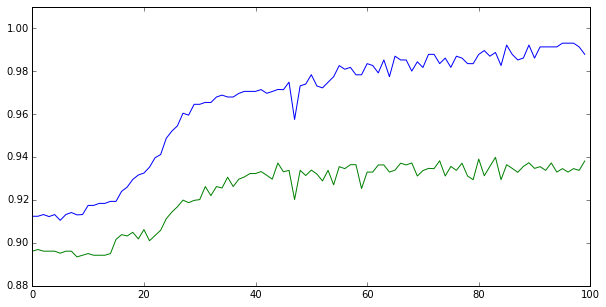

In [41]:
plt.plot(cb.epochs, cb.history['train'], label='train')
plt.plot(cb.epochs, cb.history['val'], label='val')
plt.ylim(ymax=1.01)
# plt.legend(loc=2)
plt.show()